In [34]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import os
from skimage import io, transform, color
from google.colab import drive
from random import randrange
from PIL import Image
import torch.optim as optim
import matplotlib.patches as patches
import math
import sys
from random import shuffle
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using device " + str(device))

from google.colab import drive
drive.mount('/content/drive')
%cd 
%cd /content/drive/My\ Drive/Colab\ Notebooks/project
!ls
!pwd

using device cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/root
/content/drive/My Drive/Colab Notebooks/project
cache				       project.ipynb
datasets			       results
faceset				       stylegan
faceset.zip			       supersample.ipynb
image-super-resolution		       train-scaled
karras2019stylegan-ffhq-1024x1024.pkl  train-scaled.zip
lbpcascade_animeface.xml	       transfer_learning.ipynb
/content/drive/My Drive/Colab Notebooks/project


**Downloading Pretrained Model**

In [0]:
!gdown https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ # Downloading model

Downloading...
From: https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ
To: /content/drive/My Drive/Colab Notebooks/project/karras2019stylegan-ffhq-1024x1024.pkl
325MB [00:01, 178MB/s]


In [0]:
!unzip faceset.zip -d .

Archive:  faceset.zip
replace ./faceset/3197.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
from PIL import Image
from torchvision import transforms
!pwd
!ls
!rm -rf face-resized
!mkdir face-resized

sz = (256, 256)

a = transforms.Compose([
    transforms.Resize(256)
])
for filename in os.listdir(os.getcwd() + "/faceset"):
    img = Image.open("faceset/" + filename)
    img = a(img)
    img = img.convert('RGB')

    f2 = "face-resized/"+filename
    img.save(f2)
    


/content/drive/My Drive/Colab Notebooks/project
datasets      karras2019stylegan-ffhq-1024x1024.pkl  stylegan
face-resized  lbpcascade_animeface.xml		     train-scaled
faceset       project.ipynb			     train-scaled.zip
faceset.zip   results				     transfer_learning.ipynb


In [0]:
#!cd stylegan/dataset/faces && ls
!python stylegan/dataset_tool.py create_from_images datasets/smalls/ stylegan/datasets/face-resized




Loading images from "stylegan/datasets/face-resized"
Creating dataset "datasets/smalls/"



Added 5275 images.


In [0]:
!python stylegan/train.py




Creating the run dir: results/00007-sgan-faces-1gpu
Copying files to the run dir
dnnlib: Running training.training_loop.training_loop() on localhost...



Streaming data using training.dataset.TFRecordDataset...


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
Dataset shape = [3, 256, 256]
Dynamic range = [0, 255]
Label size    = 0
Constructing networks...







G                             Params    OutputShape         WeightShape     
---                

In [0]:
%cd
%cd /content/drive/My\ Drive/Colab\ Notebooks/project/stylegan
import os
import pickle
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config
import moviepy.editor as mpy
from tqdm import tqdm_notebook as tqdm

tflib.init_tf()

/root
/content/drive/My Drive/Colab Notebooks/project/stylegan





Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3301376/45929032 bytes (7.2%)7118848/45929032 bytes (15.5%)10452992/45929032 bytes (22.8%)14213120/45929032 bytes (30.9%)17825792/45929032 bytes (38.8%)21405696/45929032 bytes (46.6%)24682496/45929032 bytes (53.7%)28475392/45929032 bytes (62.0%)32317440/45929032 bytes (70.4%)36020224/45929032 bytes (78.4%)39575552/45929032 bytes (86.2%)43393024/45929032 bytes (94.5%)

In [0]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/project
model = 'results/00007-sgan-faces-1gpu/network-snapshot-003285.pkl'

with open(model, 'rb') as f:
    _G, _D, Gs = pickle.load(f)

fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=8)

/content/drive/My Drive/Colab Notebooks/project







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
truncation = 0.7


def bookmark(latents, new_faves):
    for f in new_faves:
        faves.append(latents[f])

def show_faves(faves):
    latents = np.array(faves)
    labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
    n = len(faves)
    nr, nc = math.ceil(n / 6), 6
    for r in range(nr):
        images = Gs.run(latents[6*r:min(n-1, 6*(r+1))], None, truncation_psi=truncation, randomize_noise=False, output_transform=fmt)
        img1 = np.concatenate([img for img in images], axis=1)
        plt.figure(figsize=(24,4))
        plt.imshow(img1)
        
def random_sample(num_images, scale):
    latents = np.random.RandomState(int(1000*random.random())).randn(num_images, *Gs.input_shapes[0][1:])
    labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
    images = Gs.run(latents, None, truncation_psi=truncation, randomize_noise=False, output_transform=fmt)
    images_ct = np.concatenate([img for img in images], axis=1)
    plt.figure(figsize=(scale*num_images, scale))
    plt.imshow(images_ct)
    return images, latents

def get_latent_interpolation(endpoints, num_frames_per, mode, shuffle):
    if shuffle:
        random.shuffle(endpoints)
    num_endpoints, dim = len(endpoints), len(endpoints[0])
    num_frames = num_frames_per * num_endpoints
    endpoints = np.array(endpoints)
    latents = np.zeros((num_frames, dim))
    for e in range(num_endpoints):
        e1, e2 = e, (e+1)%num_endpoints
        for t in range(num_frames_per):
            frame = e * num_frames_per + t
            r = 0.5 - 0.5 * np.cos(np.pi*t/(num_frames_per-1)) if mode == 'ease' else float(t) / num_frames_per
            latents[frame, :] = (1.0-r) * endpoints[e1,:] + r * endpoints[e2,:]
    return latents

def get_latent_interpolation_bspline(endpoints, nf, k, s, shuffle):
    if shuffle:
        random.shuffle(endpoints)
    x = np.array(endpoints)
    x = np.append(x, x[0,:].reshape(1, x.shape[1]), axis=0)
    nd = x.shape[1]
    latents = np.zeros((nd, nf))
    nss = list(range(1, 10)) + [10]*(nd-19) + list(range(10,0,-1))
    for i in tqdm(range(nd-9)):
        idx = list(range(i,i+10))
        tck, u = interpolate.splprep([x[:,j] for j in range(i,i+10)], k=k, s=s)
        out = interpolate.splev(np.linspace(0, 1, num=nf, endpoint=True), tck)
        latents[i:i+10,:] += np.array(out)
    latents = latents / np.array(nss).reshape((512,1))
    return latents.T


def generate_images(latents, labels):
    batch_size = 8
    num_frames = latents.shape[0]
    num_batches = int(np.ceil(num_frames/batch_size))
    images = []
    for b in tqdm(range(num_batches)):
        new_images = Gs.run(latents[b*batch_size:min((b+1)*batch_size, num_frames-1), :], None, truncation_psi=truncation, randomize_noise=False, output_transform=fmt)
        for img in new_images:
            images.append(img)
    return images

def make_movie(images, out_dir, out_name):
    temp_dir = 'frames%06d'%int(1000000*random.random())
    os.system('mkdir %s'%temp_dir)
    for idx in tqdm(range(len(images))):
        PIL.Image.fromarray(images[idx], 'RGB').save('%s/frame%05d.png' % (temp_dir, idx))
    cmd = 'ffmpeg -i %s/frame%%05d.png -c:v libx264 -pix_fmt yuv420p %s/%s.mp4' % (temp_dir, out_dir, out_name)
    print(cmd)
    os.system(cmd)
    os.system('rm -rf %s'%temp_dir)

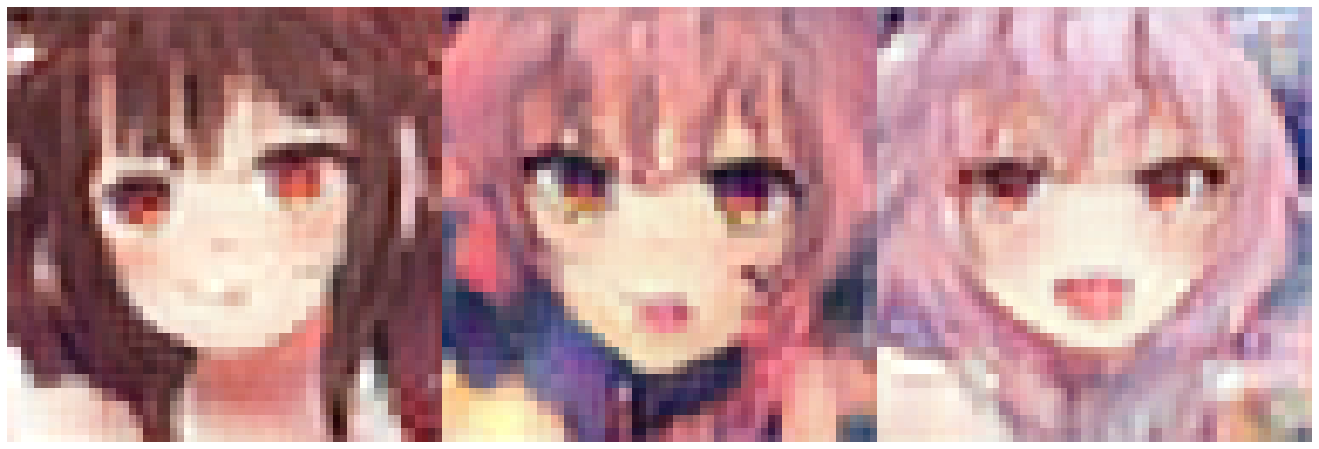

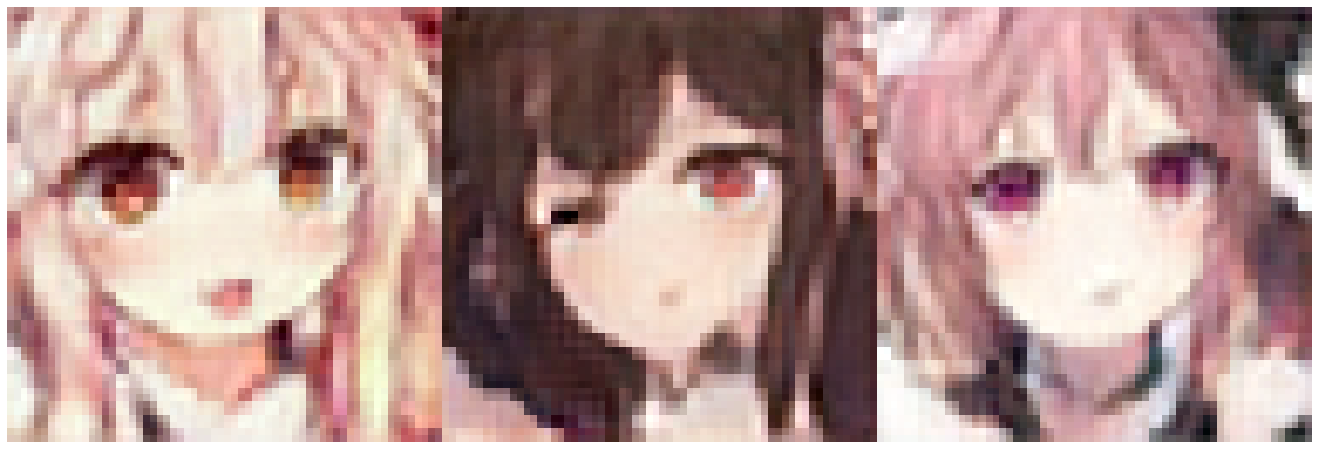

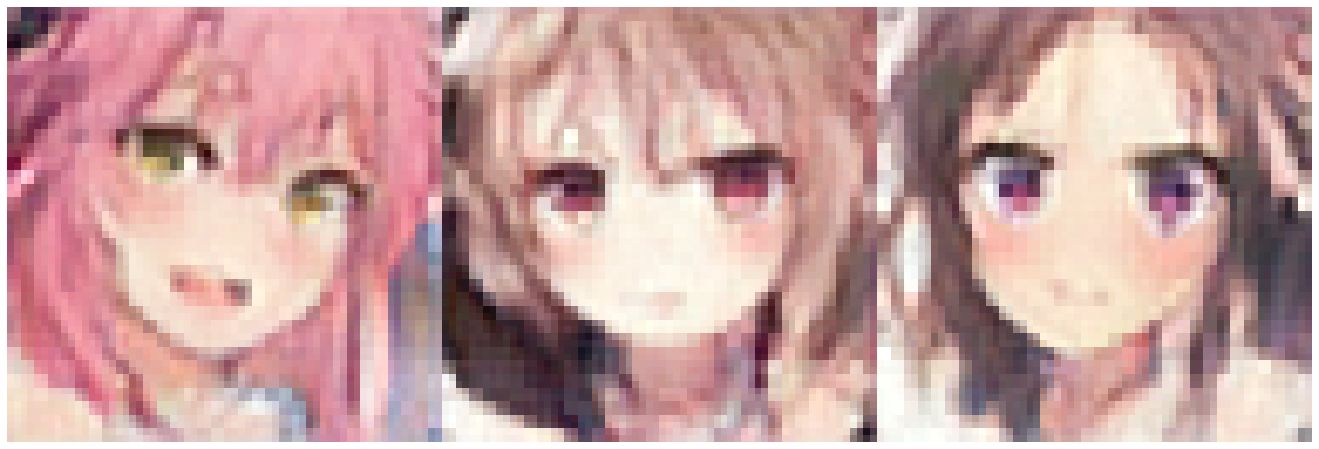

In [38]:
def random_sample(num_images, scale):
    latents = np.random.RandomState(int(1000*random.random())).randn(num_images, *Gs.input_shapes[0][1:])
    labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
    images = Gs.run(latents, None, truncation_psi=truncation, randomize_noise=False, output_transform=fmt)
    images_ct = np.concatenate([img for img in images], axis=1)
    plt.figure(figsize=(scale*num_images, scale))
    plt.imshow(images_ct)
    plt.axis('off')
    #plt.savefig('download.png')
    return images, latents

GAN_images, latents = random_sample(3, scale=8)
GAN_images, latents = random_sample(3, scale=8)
GAN_images, latents = random_sample(3, scale=8)